In [43]:
import time
import math
import pickle
import pandas as pd
#import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import linear_model
from sklearn.calibration import calibration_curve 
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder, normalize
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss, make_scorer , f1_score, accuracy_score, log_loss
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [44]:
filename_train = 'criminal_train.csv'
filename_test = 'criminal_test.csv'
trainall = pd.read_csv('{}'.format(filename_train),header=0)
test = pd.read_csv('{}'.format(filename_test),header=0)

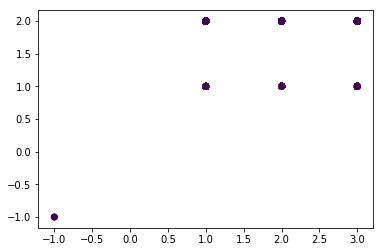

In [45]:
""" Summary of missinf values in the dataset """
trainall.isnull().sum(axis= 0)/trainall.shape[0]
# we have no missing values in this dataset.

PERID        0.0
IFATHER      0.0
NRCH17_2     0.0
IRHHSIZ2     0.0
IIHHSIZ2     0.0
IRKI17_2     0.0
IIKI17_2     0.0
IRHH65_2     0.0
IIHH65_2     0.0
PRXRETRY     0.0
PRXYDATA     0.0
MEDICARE     0.0
CAIDCHIP     0.0
CHAMPUS      0.0
PRVHLTIN     0.0
GRPHLTIN     0.0
HLTINNOS     0.0
HLCNOTYR     0.0
HLCNOTMO     0.0
HLCLAST      0.0
HLLOSRSN     0.0
HLNVCOST     0.0
HLNVOFFR     0.0
HLNVREF      0.0
HLNVNEED     0.0
HLNVSOR      0.0
IRMCDCHP     0.0
IIMCDCHP     0.0
IRMEDICR     0.0
IIMEDICR     0.0
            ... 
CELLNOTCL    0.0
CELLWRKNG    0.0
IRFAMSOC     0.0
IIFAMSOC     0.0
IRFAMSSI     0.0
IIFAMSSI     0.0
IRFSTAMP     0.0
IIFSTAMP     0.0
IRFAMPMT     0.0
IIFAMPMT     0.0
IRFAMSVC     0.0
IIFAMSVC     0.0
IRWELMOS     0.0
IIWELMOS     0.0
IRPINC3      0.0
IRFAMIN3     0.0
IIPINC3      0.0
IIFAMIN3     0.0
GOVTPROG     0.0
POVERTY3     0.0
TOOLONG      0.0
TROUBUND     0.0
PDEN10       0.0
COUTYP2      0.0
MAIIN102     0.0
AIIND102     0.0
ANALWT_C     0.0
VESTR        0

### Category of features
- Healthcare
- Cellphone
- Welfare benefits
- family income/poverty level
- metro status - information about the neighbourhood
- American Indian 

no data imputation or dummying out of variables is required

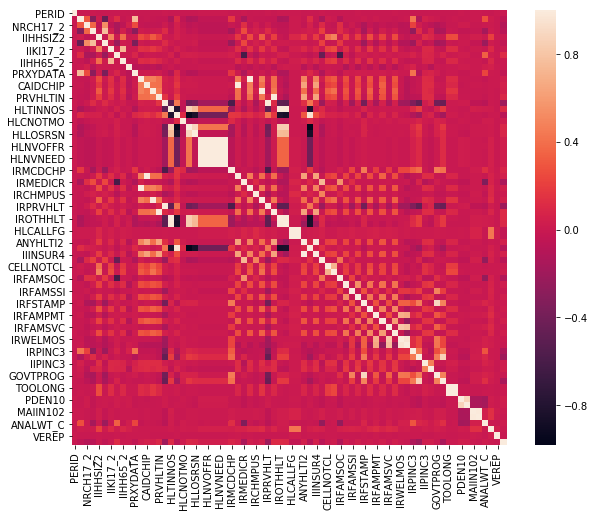

In [4]:
import seaborn as sns
""" Correlation map """
corrheatmap_all = trainall.corr()
f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corrheatmap_all, square=True)

In [5]:
print('Size of training set = ',trainall.shape)
print('Column names =', trainall.columns.values)
# independent variables
x = list(trainall.columns.values)[:-1]
# dependent variable
y = 'Criminal'
#dftrain.head()

corrxy= trainall[x].corrwith(trainall[y])
corrxy.sort_values(ascending = False)

Size of training set =  (45718, 72)
Column names = ['PERID' 'IFATHER' 'NRCH17_2' 'IRHHSIZ2' 'IIHHSIZ2' 'IRKI17_2' 'IIKI17_2'
 'IRHH65_2' 'IIHH65_2' 'PRXRETRY' 'PRXYDATA' 'MEDICARE' 'CAIDCHIP'
 'CHAMPUS' 'PRVHLTIN' 'GRPHLTIN' 'HLTINNOS' 'HLCNOTYR' 'HLCNOTMO' 'HLCLAST'
 'HLLOSRSN' 'HLNVCOST' 'HLNVOFFR' 'HLNVREF' 'HLNVNEED' 'HLNVSOR' 'IRMCDCHP'
 'IIMCDCHP' 'IRMEDICR' 'IIMEDICR' 'IRCHMPUS' 'IICHMPUS' 'IRPRVHLT'
 'IIPRVHLT' 'IROTHHLT' 'IIOTHHLT' 'HLCALLFG' 'HLCALL99' 'ANYHLTI2'
 'IRINSUR4' 'IIINSUR4' 'OTHINS' 'CELLNOTCL' 'CELLWRKNG' 'IRFAMSOC'
 'IIFAMSOC' 'IRFAMSSI' 'IIFAMSSI' 'IRFSTAMP' 'IIFSTAMP' 'IRFAMPMT'
 'IIFAMPMT' 'IRFAMSVC' 'IIFAMSVC' 'IRWELMOS' 'IIWELMOS' 'IRPINC3'
 'IRFAMIN3' 'IIPINC3' 'IIFAMIN3' 'GOVTPROG' 'POVERTY3' 'TOOLONG' 'TROUBUND'
 'PDEN10' 'COUTYP2' 'MAIIN102' 'AIIND102' 'ANALWT_C' 'VESTR' 'VEREP'
 'Criminal']


IRHH65_2    0.112589
HLTINNOS    0.106967
IROTHHLT    0.104196
IIPRVHLT    0.103360
IIOTHHLT    0.095032
HLCLAST     0.091338
PRVHLTIN    0.089960
IRMCDCHP    0.081704
HLLOSRSN    0.081006
CAIDCHIP    0.052671
IIINSUR4    0.049871
IIMCDCHP    0.048222
ANYHLTI2    0.046698
CHAMPUS     0.040844
IICHMPUS    0.040529
HLNVREF     0.038382
HLNVCOST    0.038380
HLNVSOR     0.038379
HLNVOFFR    0.038379
HLNVNEED    0.038378
IIFAMSSI    0.038064
IIMEDICR    0.037516
IIFAMIN3    0.037193
IIFAMSVC    0.035574
IIFAMPMT    0.034474
PDEN10      0.033048
COUTYP2     0.031587
MEDICARE    0.031178
IIPINC3     0.029628
IIFAMSOC    0.026832
              ...   
PRXRETRY    0.004966
IRFAMPMT    0.004810
IIHH65_2    0.004112
VESTR       0.002355
MAIIN102    0.002309
IRWELMOS    0.001917
GOVTPROG    0.001719
AIIND102    0.001484
PERID      -0.000396
IRFAMSVC   -0.000553
IRFAMSSI   -0.002666
IIWELMOS   -0.007639
VEREP      -0.007738
HLCALLFG   -0.034450
HLCALL99   -0.034450
PRXYDATA   -0.038797
IRKI17_2   -0

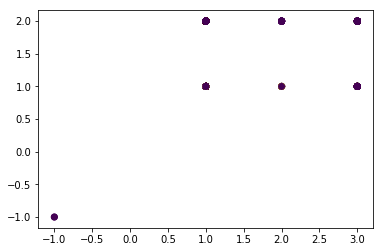

In [115]:
plt.scatter(trainall[x[8]],trainall['IRPRVHLT'],c=trainall['Criminal'])
plt.show()

In [6]:
(trainall.Criminal.sum())

0.069447482392055643

The biggest hurdle in modeling this data is the unbalanced classes. The dataset contains 7% percent criminals and rest non-criminals. 
I would proceed by following a standard procedure for anamoly detection. Don't know how to do it right now. 

In [72]:
# Divide into holdout and training sets
msk = np.random.rand(len(trainall)) < 0.8
train = pd.DataFrame(trainall[msk])
hdout = pd.DataFrame(trainall[~msk])

In [59]:
#define hyperparamter distribution

def model_params_dist(model_key):
    from scipy.stats import randint
    params_dists = {
        'RandomForest': {
             "n_estimators": [300,400],
             "max_depth": [3, None],
             "max_features": randint(1, 11),
             "min_samples_split": randint(2, 11),
             "min_samples_leaf": randint(1, 11),
             "bootstrap": [True, False],
             "criterion": ["gini", "entropy"],
             "random_state":[130],
             "n_jobs":[-1]
         },
        'XGBoost': {
            "n_estimators":[300,400],
             "max_depth": [3, 5],
             "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
             "booster": ['gbtree','gblinear','dart'],
             "n_jobs":[-1],
             "random_state":[130]
         },
        'LogisticRegression': {
            'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,10000,100000]
             
         }
    }
    return params_dists[model_key]


# elect2 xgboost tuning grid
# {'max_depth': [1, 5, 10], 'max_delta_step': [1, 5, 10], 
#   'subsample': [0.5, 1], 'reg_lambda': [0, 0.5, 1], 'learning_rate': [0.1, 0.05], 
#   'reg_alpha': [0, 0.5, 1], 'colsample_bytree': [0.5, 1]}


def check_max_n_iter(dist):
    import numpy
    from sklearn.model_selection import ParameterGrid
    all_lists = numpy.all([not hasattr(v, "rvs")
                            for v in dist.values()])
    if all_lists:
        param_grid = ParameterGrid(dist)
        return len(param_grid)        
    return float('infinity')

In [8]:
# svm
%time
from sklearn.svm import SVC
clf = SVC()
clf.fit(train[x], train[y])
SVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, probability=False, random_state=None,
      shrinking=True, tol=0.001, verbose=False)


Wall time: 0 ns


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
import pickle
pickle.dump(clf, open("model_object_svm_.pickle.dat", "wb"))

In [10]:
predictions = clf.predict(hdout[x])

In [15]:
clf.score(hdout[x],hdout[y])

0.93266397468078144

In [178]:
train_x , train_y = train[x], train[y]
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
ss = SMOTE(n_jobs=-1)
cc = ClusterCentroids(random_state=0,n_jobs= -1)
train_x_resampled,train_y_resampled = cc.fit_sample(train_x, train_y)

#oversamp = os.SMOTE()
#train_x, train_y = oversamp.fit_sample(train[x], train[y])
# len(train_x_resampled)

In [173]:
len(train_x_resampled)

57010

In [177]:
clf = linear_model.LogisticRegression()
clf.fit(train_x_resampled, train_y_resampled)
hdout_predict = clf.predict(hdout[x])
accuracy_score(hdout2[y], hdout_predict), metrics.recall_score(hdout2[y], hdout_predict)

(0.45457541469845109, 0.95921696574225124)

In [39]:
#hdtest = hdout[x]
pred = clf.predict(test[x])
test2 = test[['PERID']]
Criminal = [a for a in pred]
test2['Criminal'] = Criminal

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


numpy.ndarray

In [73]:
model_key = 'XGBoost'


models_dir = {"RandomForest" : RandomForestClassifier(),
          "LogisticRegression": linear_model.LogisticRegression(),
           "XGBoost" : xgb.XGBClassifier()}
    

if model_key == 'LogisticRegression':        
    # scale/ normalize the train and test sets separately
    train = normalize(train, norm='l1')
    hdout = normalize(hdout, norm='l1') 
    

    
clf = models_dir[model_key]     

# Tuning hyper parameters and training the model with best hyper-parameters
param_dist = model_params_dist(model_key)
k_fold =  StratifiedKFold(n_splits=10, shuffle=True)
k_fold.get_n_splits(train[x],train[y])

# set n_iter
n_iter = 20        
if check_max_n_iter(model_params_dist(model_key)) < n_iter:
    n_iter = check_max_n_iter(model_params_dist(model_key))


random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter, scoring='accuracy', cv=k_fold, n_jobs=-1)
random_search.fit(train[x],train[y])

# Predictions using the model with best hyper-parameters
# predictions = random_search.predict_proba(hdout[x])
# probs = [e1[1] for e1 in predictions]
# hdout2 = hdout
# hdout['probs'] = probs
# hdout2['predictions'] = hdout2['probs'].round(0)

# best_params = random_search.best_params_      

# metrics={'brier_score': brier_score_loss(hold2[y], hold2['probs']),'log_loss': log_loss(hold2[y], hold2['probs'])}  

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'n_estimators': [300, 400], 'max_depth': [3, 5], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'booster': ['gbtree', 'gblinear', 'dart'], 'n_jobs': [-1], 'random_state': [130]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [80]:
# Predictions using the model with best hyper-parameters
predictions = random_search.predict_proba(hdout[x])
probs = [e1[1] for e1 in predictions]
hdout2 = hdout
hdout['probs'] = probs
hdout2['predictions'] = hdout2['probs'].round(0)

best_params = random_search.best_params_      

metrics={'brier_score': brier_score_loss(hdout2[y], hdout2['probs']),'log_loss': log_loss(hdout2[y], hdout2['probs'])}  
         

In [97]:
hdout2.loc[hdout2['Criminal'] == 1]

,PERID,IFATHER,NRCH17_2,IRHHSIZ2,IIHHSIZ2,IRKI17_2,IIKI17_2,IRHH65_2,IIHH65_2,PRXRETRY,...,PDEN10,COUTYP2,MAIIN102,AIIND102,ANALWT_C,VESTR,VEREP,Criminal,probs,predictions
43,77291143,4,0,2,1,1,1,3,1,99,...,2,2,2,2,3492.660971,40048,2,1,0.507569,1.0
61,13343143,4,0,2,1,1,1,3,1,99,...,2,2,2,2,10067.000170,40025,2,1,0.507569,1.0
230,85726443,4,0,1,1,1,1,2,1,99,...,1,1,2,2,11914.934100,40021,1,1,0.484231,0.0
326,77110543,1,0,4,1,3,1,1,1,99,...,1,1,2,2,517.166183,40020,1,1,0.509698,1.0
403,35622643,4,0,1,1,1,1,2,1,99,...,2,2,2,2,24264.314100,40034,2,1,0.507569,1.0
513,31465843,4,0,2,1,1,1,3,1,99,...,3,3,2,2,1786.335092,40036,1,1,0.507569,1.0
658,68035043,4,0,3,1,2,1,1,1,99,...,1,1,2,2,3094.562234,40049,2,1,0.495131,0.0
868,79873253,4,1,3,1,2,1,1,1,99,...,2,3,2,2,6213.196683,40009,2,1,0.495131,0.0
886,14596353,4,0,3,1,1,1,2,1,99,...,1,1,2,2,17215.377970,40029,1,1,0.507569,1.0
1022,27845553,1,0,5,1,3,1,1,1,99,...,3,3,2,2,1867.052455,40047,2,1,0.509698,1.0


In [31]:
clf = RandomForestClassifier(bootstrap=True, criterion='entropy', max_depth=None, max_features=8, min_samples_leaf=6,
                             min_samples_split=6, n_estimators=400, n_jobs=-1,random_state=130)
clf.fit(trainall[x],trainall[y])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False, random_state=130,
            verbose=0, warm_start=False)

In [98]:
#gbm = models_dir[model_key]
#gbm.set_params(*best_params.fit(trainall[x],trainall[y]))
#pickle.dump(gbm, open("model_object.pickle.dat", "wb"))
predictions_score = random_search.predict_proba(test[x])
#predictions_score = clf.predict_proba(test[x])
probs = [e1[1] for e1 in predictions_score]
Criminal = [1 if p>= 0.5 else 0 for p in probs]
test2 = test[['PERID']]
test2['probs'] = probs
test2['Criminal']= Criminal

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


ValueError: Found input variables with inconsistent numbers of samples: [9103, 11430]

In [99]:
test2[['PERID','Criminal']].to_csv('submit_rf_20180223.csv',header=1,index=False)
test2.to_csv('test_smote_20180323.csv',header=1,index=False)

In [34]:
test2

,PERID,probs,Criminal
0,66583679,0.118617,0
1,35494679,0.000375,0
2,79424679,0.000081,0
3,11744679,0.001757,0
4,31554679,0.001577,0
5,83164679,0.000683,0
6,58474679,0.012711,0
7,40695779,0.231251,0
8,39315779,0.004966,0
9,58415779,0.093320,0
